In [2]:
!pip install tensorflow-addons tensorflow-datasets

     |████████████████████████████████| 1.1 MB 4.4 MB/s 


In [3]:
import typing
import numpy as np
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

### Download the training data, takes a few minutes

In [4]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)
num_classes = metadata.features["label"].num_classes
train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
get_label_name = metadata.features['label'].int2str

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Inspect samples from the dataset

In [5]:
def visualize_samples(dataset):
    for sample in dataset.take(5):
        plt.imshow(tf.cast(sample[0], tf.int64))
        plt.title(get_label_name(sample[1]))
        plt.show()
        plt.clf()

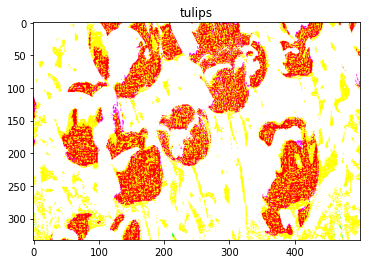

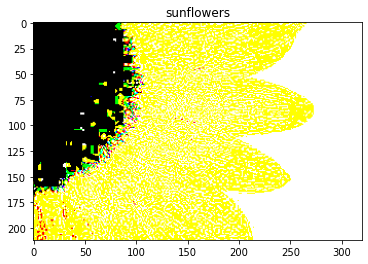

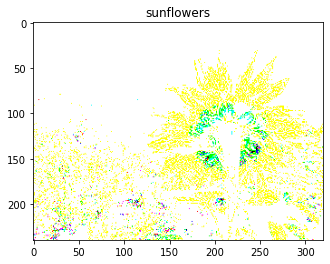

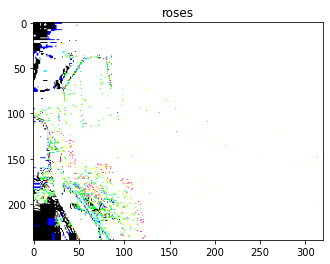

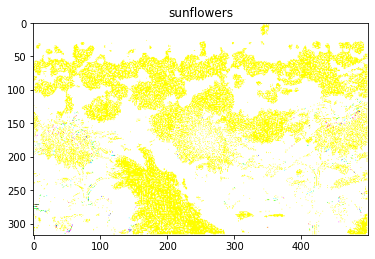

<Figure size 432x288 with 0 Axes>

In [6]:
visualize_samples(train_ds)

### Analyze the dataset's properties

In [7]:
def inspect_dataset(dataset: tf.data.Dataset):
    height = []
    width = []
    labels = {}
    for sample in dataset:
        shape = sample[0].shape
        height.append(shape[0])
        width.append(shape[1])
        cur_count = labels.get(sample[1].numpy(), 0)

        labels[sample[1].numpy()] = cur_count + 1

    return height, width, labels

In [8]:
def plot_histograms(lens, subtitle):
    fig = plt.figure(1, figsize=(10, 5))
    ax1 = plt.subplot(1, 2, 1)
    plt.hist(lens, bins=50)
    plt.title("Length")
    plt.ylabel("Number of samples")
    ax1.tick_params('x', labelrotation=-45)
    ax2 = plt.subplot(1, 2, 2)
    plt.hist(lens, bins=20, cumulative=True)
    plt.title("Cumulative lengths")
    ax2.tick_params('x', labelrotation=-45)


    plt.subplots_adjust(bottom=0.2)

In [9]:
height, width, labels = inspect_dataset(train_ds)

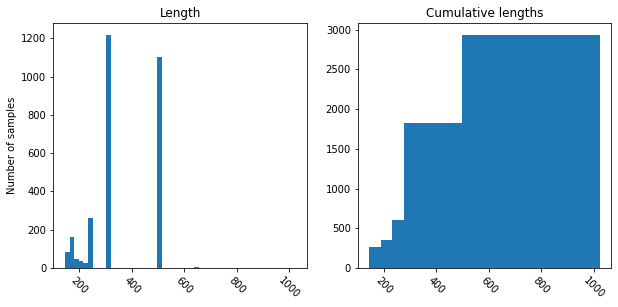

In [10]:
plot_histograms(width, "Width")

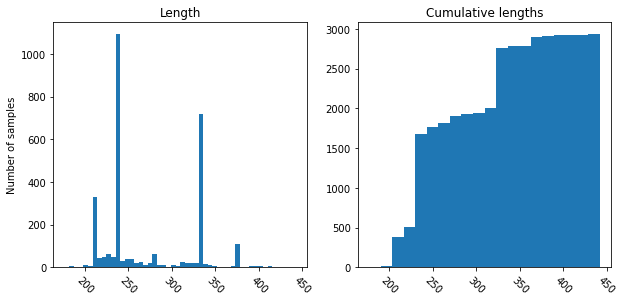

In [11]:
plot_histograms(height, "Height")

In [12]:
np.quantile(height, q=[0.1, 0.2, 0.5, 0.6, 0.7, 0.8, 0.9])

array([213., 238., 240., 256., 331., 333., 333.])

Look at the label distribution within the trainings set

In [13]:
labels

{0: 739, 1: 513, 2: 613, 3: 561, 4: 510}

From this information, we know that the labels are unbalanced, thus accuracy alone will not be meaningful --> use the F1 metric

Let's pick reasonable sizes to reshape the data to, based on what we inferred from the histograms

In [14]:
img_height = 350
img_width = 500

In [15]:
def reshape_image_dataset(dataset: tf.data.Dataset):
    dataset = dataset.map(
        lambda image, label: (tf.image.resize_with_pad(image, target_height=img_height, target_width=img_width), label))
    return dataset

In [16]:
train_ds = reshape_image_dataset(train_ds)
val_ds = reshape_image_dataset(val_ds)
test_ds = reshape_image_dataset(test_ds)

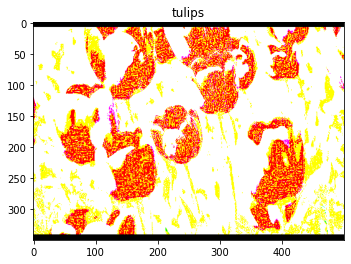

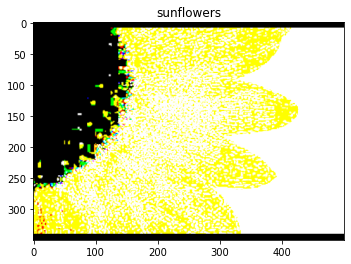

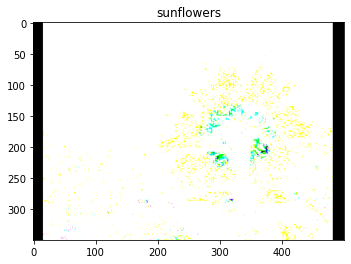

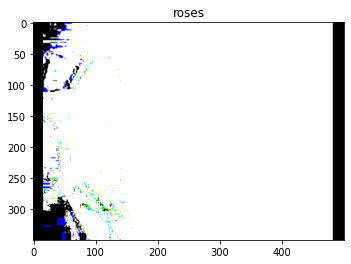

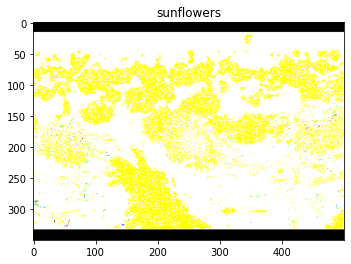

<Figure size 432x288 with 0 Axes>

In [17]:
visualize_samples(train_ds)

### Add the augmentation pipeline

In [18]:
@tf.function
def augment_image_batch(image_and_label, seed):
    image, label = image_and_label
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_brightness(image, max_delta=0.3, seed=new_seed)
    image = tf.clip_by_value(image, 0.0, 255.0)
    image = tf.image.stateless_random_flip_left_right(image, seed=new_seed)
    image = tf.image.stateless_random_flip_up_down(image, seed=new_seed)
    return image, label, seed

Applying the augmentations after batching is faster --> batch first

In [19]:
train_ds_batched = train_ds.batch(32, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False, drop_remainder=False)
val_ds = val_ds.batch(32, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False, drop_remainder=False)
test_ds = test_ds.batch(32, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False, drop_remainder=False)

Add a "seed" for reproducibility

In [20]:
counter = tf.data.experimental.Counter()
temporary_ds = tf.data.Dataset.zip((train_ds_batched, (counter, counter)))
temporary_ds = temporary_ds.map(augment_image_batch)

In [21]:
def visualize_samples_batch(dataset):
    for sample in dataset.take(5):
        plt.imshow(tf.cast(sample[0][0], tf.int64))
        plt.title(get_label_name(sample[1][0]))
        plt.show()
        plt.clf()

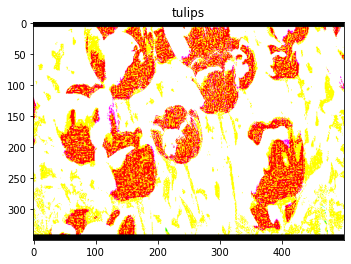

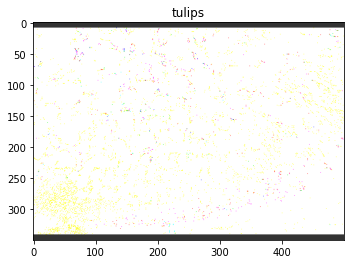

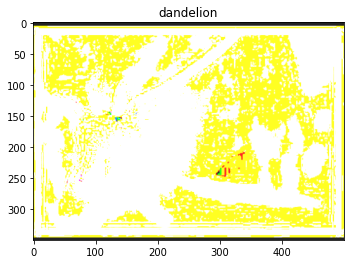

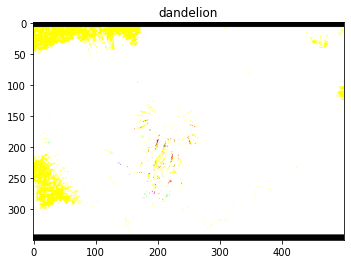

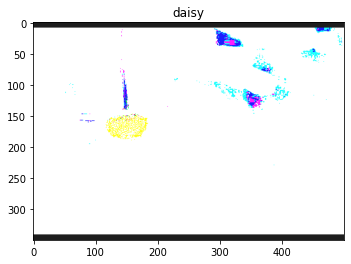

<Figure size 432x288 with 0 Axes>

In [22]:
visualize_samples_batch(temporary_ds)

Add further augmentations: image rotation

In [23]:
@tf.function
def rotate_image(feature, label, seed):
    num_samples = int(tf.shape(feature)[0])
    degrees = tf.random.stateless_uniform(
        shape=(num_samples,), seed=seed, minval=-45, maxval=45
    )
    degrees = degrees * 0.017453292519943295  # convert the angle in degree to radians

    rotated_images = tfa.image.rotate(feature, degrees)

    return rotated_images, label

In [24]:
temporary_ds = temporary_ds.map(rotate_image, num_parallel_calls=tf.data.AUTOTUNE)

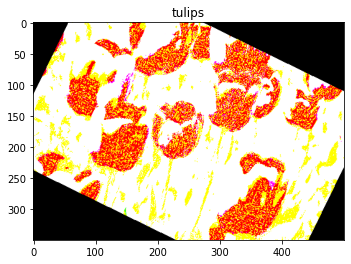

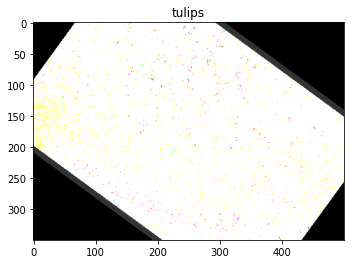

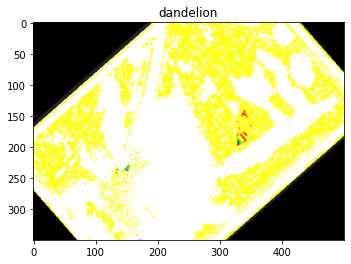

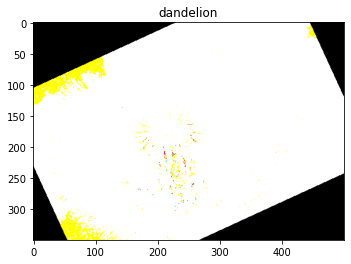

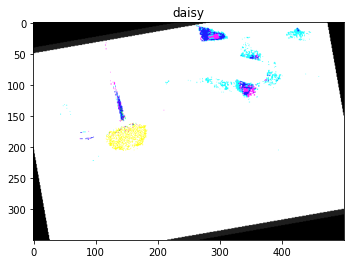

<Figure size 432x288 with 0 Axes>

In [25]:
visualize_samples_batch(temporary_ds)

Let's wrap the previous steps into a single function

In [26]:
def add_augmentations(dataset, use_augmentations: bool = True):
    if not use_augmentations:
        print("Not augmenting the image data.")
        return dataset

    print("Augmenting the image data.")
    counter = tf.data.experimental.Counter()
    dataset = tf.data.Dataset.zip((dataset, (counter, counter)))
    augmented_dataset = dataset.map(augment_image_batch)
    augmented_dataset = augmented_dataset.map(
        rotate_image
    )  # we have to add the rotation operation manually; it's not yet part of native TensorFlow

    return augmented_dataset

In [27]:
train_ds_augmented = add_augmentations(train_ds_batched, use_augmentations=True)

Augmenting the image data.


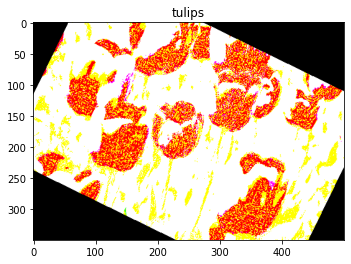

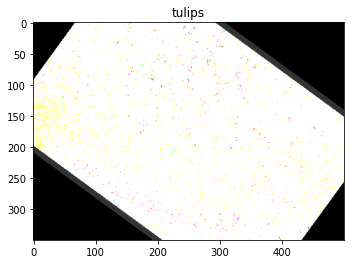

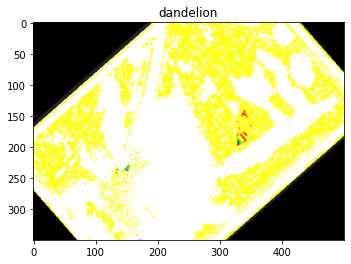

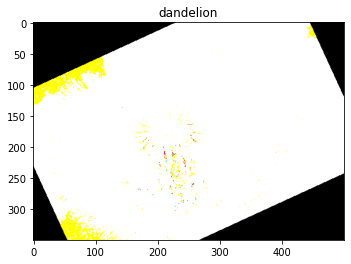

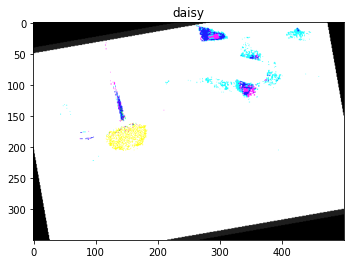

<Figure size 432x288 with 0 Axes>

In [28]:
visualize_samples_batch(train_ds_augmented)

In [29]:
def get_strategy(xla: bool, fp16: bool, no_cuda: bool):
    """
    Determines the strategy under which the network is trained.

    From https://github.com/huggingface/transformers/blob/8eb7f26d5d9ce42eb88be6f0150b22a41d76a93d/src/transformers/training_args_tf.py

    returns the strategy object

    """

    if xla:
        tf.config.optimizer.set_jit(True)
    visible_devices = tf.config.get_visible_devices("GPU")
    # Set to float16 at first
    if fp16:
        policy = tf.keras.mixed_precision.experimental.Policy("mixed_float16")
        tf.keras.mixed_precision.experimental.set_policy(policy)

    if no_cuda:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
    else:
        try:
            tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        except ValueError:
            tpu = None

        if tpu:
            # Set to bfloat16 in case of TPU
            if fp16:
                policy = tf.keras.mixed_precision.experimental.Policy("mixed_bfloat16")
                tf.keras.mixed_precision.experimental.set_policy(policy)
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)

            strategy = tf.distribute.experimental.TPUStrategy(tpu)

        elif len(visible_devices) == 0:
            strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
        elif len(visible_devices) == 1:
            strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
        elif len(visible_devices) > 1:
            # If you only want to use a specific subset of GPUs use `CUDA_VISIBLE_DEVICES=0`
            strategy = tf.distribute.MirroredStrategy(
                cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()
            )
        else:
            raise ValueError(
                "Cannot find the proper strategy! Please check your environment properties."
            )

    return strategy, len(visible_devices)

In [30]:
def create_model(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(shape=input_shape)

    core = tf.keras.applications.resnet_v2.ResNet50V2(
        input_tensor=input_layer, include_top=False, pooling="avg"
    )
    output = tf.keras.layers.Dense(units=num_classes)(core.output)

    return tf.keras.models.Model(input_layer, output)

In [31]:
strategy, num_devices = get_strategy(False, False, False)

In [32]:
with strategy.scope():
    model = create_model(input_shape=(img_height, img_width, 3), num_classes=len(labels))

94683136/94668760 [==============================] - 0s 0us/step


In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 356, 506, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 175, 250, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [34]:
train_ds_augmented = train_ds_augmented.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes)))

In [35]:
with strategy.scope():
    optimizer = keras.optimizers.Adam()
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    f1_macro = tfa.metrics.F1Score(num_classes=len(labels), average="macro", name="f1_macro")
    f1_micro = tfa.metrics.F1Score(num_classes=len(labels), average="micro", name="f1_micro")
    accuracy = keras.metrics.CategoricalAccuracy()

In [36]:
with strategy.scope():
    model: keras.models.Model
    model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy, f1_micro, f1_macro])

In [37]:
def count_batches(dataset):
  counter = 0
  for _ in dataset:
    counter += 1

  return counter

In [38]:
train_counter = count_batches(train_ds_augmented)
val_counter = count_batches(val_ds)
test_counter = count_batches(test_ds)

In [39]:
train_ds_augmented = strategy.experimental_distribute_dataset(train_ds_augmented.repeat())
val_ds = strategy.experimental_distribute_dataset(val_ds.repeat())
test_ds = strategy.experimental_distribute_dataset(test_ds)

In [ ]:
model.fit(train_ds_augmented, validation_data=val_ds, epochs=20, steps_per_epoch=train_counter, validation_steps=val_counter)

Epoch 1/20
92/92 [==============================] - 125s 1s/step - loss: 1.0630 - categorical_accuracy: 0.6127 - f1_micro: 0.6127 - f1_macro: 0.6039 - val_loss: 92.9498 - val_categorical_accuracy: 0.1635 - val_f1_micro: 0.1635 - val_f1_macro: 0.0598
Epoch 2/20
92/92 [==============================] - 100s 1s/step - loss: 0.7008 - categorical_accuracy: 0.7408 - f1_micro: 0.7408 - f1_macro: 0.7339 - val_loss: 0.6766 - val_categorical_accuracy: 0.7875 - val_f1_micro: 0.7875 - val_f1_macro: 0.7726
Epoch 3/20
92/92 [==============================] - 102s 1s/step - loss: 0.5127 - categorical_accuracy: 0.8110 - f1_micro: 0.8110 - f1_macro: 0.8076 - val_loss: 1.1233 - val_categorical_accuracy: 0.6730 - val_f1_micro: 0.6730 - val_f1_macro: 0.6512
Epoch 4/20
92/92 [==============================] - 101s 1s/step - loss: 0.4587 - categorical_accuracy: 0.8307 - f1_micro: 0.8307 - f1_macro: 0.8283 - val_loss: 1.9542 - val_categorical_accuracy: 0.6540 - val_f1_micro: 0.6540 - val_f1_macro: 0.5874
Epo